<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/7%20Feature%20selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Engineering & Feature selection**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install openpyxl -q
import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# for grid
!pip install geopy -q
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# CatBoost
!pip install catboost -q
from catboost import CatBoostRegressor, Pool
# XGBoost
import xgboost as xgb
# RandomForest
from sklearn.ensemble import RandomForestRegressor
# Linear Regression+l1 Lasso
from sklearn.linear_model import Lasso


from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

!pip -qq install category_encoders
from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer


# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments_5.xlsx', engine='openpyxl')

In [2]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments5.pkl -q

with open('apartments5.pkl', 'rb') as f:
    apartments = pickle.load(f)


drop notinformative columns Encodinf

In [4]:
apartments.drop(columns=['Host Since','First Review', 'Last Review','Reviews', 'Price Log', 'Latitude_Bin', 'Longitude_Bin' ], inplace=True)

In [5]:
apartments['Is Superhost'] = apartments['Is Superhost'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Instant Bookable'] = apartments['Instant Bookable'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Is Exact Location'] = apartments['Is Exact Location'].replace({'t': 1, 'f': 0}).fillna(0).astype(int)
apartments['Property Type'] = apartments['Property Type'].replace({'Apartment': 1, 'Condominium': 0}).fillna(0).astype(int)
apartments['Room Type'] = apartments['Room Type'].replace({'Private room': 1, 'Entire home/apt': 0}).fillna(0).astype(int)

apartments['Host Response Time'] = apartments['Host Response Time'].replace(
    {'within an hour':0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3 }).fillna(0).astype(int)

In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

Value counts for column 'Listing ID' :
Listing ID
10002699    1
30934593    1
30947505    1
30946969    1
30946705    1
           ..
20716366    1
20716294    1
20710491    1
20710283    1
9996186     1
Name: count, Length: 19664, dtype: int64
NaN values: 0 


Value counts for column 'neighbourhood' :
neighbourhood
NeukÃ¶lln                3182
Prenzlauer Berg          2550
Kreuzberg                2509
Friedrichshain           2460
Mitte                    1749
Wedding                  1316
SchÃ¶neberg               935
Moabit                    715
Charlottenburg            696
Wilmersdorf               400
Pankow                    272
Rummelsburg               223
Tempelhof                 220
WeiÃensee                181
Lichtenberg               166
Alt-Treptow               156
Tiergarten                153
Steglitz                  135
Reinickendorf             133
Westend                    89
Lichterfelde               89
Friedenau                  77
Baumschulenweg        

In [ ]:
# prompt: значения 'neighbourhood' по которым менее 10 наблюдений заменить на "other"

# neighbourhood_counts = apartments['neighbourhood'].value_counts()
# apartments['neighbourhood'] = np.where(apartments['neighbourhood'].isin(neighbourhood_counts[neighbourhood_counts >= 10].index), apartments['neighbourhood'], 'Other')

# Postal_counts = apartments['Postal Code'].value_counts()
# apartments['Postal Code'] = np.where(apartments['Postal Code'].isin(Postal_counts[Postal_counts >= 10].index), apartments['Postal Code'], 'Other')
# Postal_counts

,count
Postal Code,
10245.0,855
10247.0,749
10437.0,658
10115.0,580
10999.0,542
10405.0,517
10997.0,517
10439.0,507
10119.0,485


# **Random forest**

In [25]:
X = apartments.drop(columns=['Listing ID', 'Price'])
y = apartments['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

# X_train[col_train_obj] = X_train[col_train_obj].fillna('abr@cadabra')
# X_test[col_test_obj] = X_test[col_test_obj].fillna('abr@cadabra')

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=3,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', RandomForestRegressor(n_jobs=-1,
                              n_estimators = 300,
                              # max_depth = 12,
                              min_impurity_decrease = 0.1,
                              min_samples_split = 3,
                              max_features = 'sqrt',
                              random_state = 142
                              ))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))

Train RMSE: 14.24214188267961
Test RMSE: 26.689209758848136
R²: 0.5200103439013377
Train MAE: 10.681447294397847
Test MAE: 17.1781827665134


                                   Feature  Importance
11                    remainder__Room Type    0.138558
12                  remainder__Accomodates    0.127483
3              mean_target_encode__Bin-Bin    0.120181
14                     remainder__Bedrooms    0.101975
15                         remainder__Beds    0.052230
16              remainder__Guests Included    0.049043
2          mean_target_encode__Postal Code    0.041925
34         remainder__Distance_from_center    0.030740
13                    remainder__Bathrooms    0.029965
30             remainder__Host Since Years    0.026382
8                     remainder__Longitude    0.025599
0        mean_target_encode__neighbourhood    0.024174
7                      remainder__Latitude    0.023954
31            remainder__Last Review Years    0.022774
29                remainder__Polarity_mean    0.019486
28              remainder__Polarity_median    0.017368
32           remainder__First Review Years    0.017202
5         

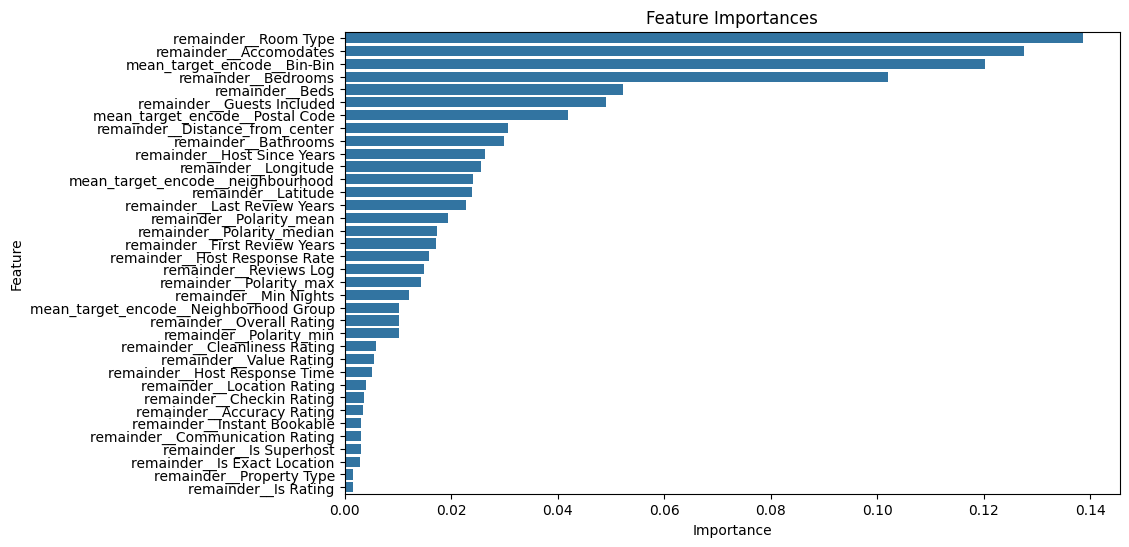

In [10]:
# prompt: важность признаков для RandomForestRegressor

# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# **Lasso**

In [53]:
X = apartments.drop(columns=['Listing ID', 'Price'])
y = apartments['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

col_train_num = X_train.select_dtypes('number').columns
col_test_num = X_test.select_dtypes('number').columns

X_train[col_train_num] = X_train[col_train_num].fillna(X_train[col_train_num].mean())
X_test[col_test_num] = X_test[col_test_num].fillna(X_train[col_train_num].mean())

col_train_obj = X_train.select_dtypes(exclude='number').columns
col_test_obj = X_test.select_dtypes(exclude='number').columns

# X_train[col_train_obj] = X_train[col_train_obj].fillna('abr@cadabra')
# X_test[col_test_obj] = X_test[col_test_obj].fillna('abr@cadabra')

preprocessor = ColumnTransformer(
    transformers=[
        ('mean_target_encode', TargetEncoder(
                                             min_samples_leaf=3,
                                             #smoothing=10,
                                             handle_missing='value',
                                             handle_unknown='value'
        ), col_train_obj),
     ],
    remainder='passthrough'
)

pipeline = Pipeline([
                    ('preprocessor', preprocessor
                     ),

                    ('model', Lasso(alpha = 0.01, max_iter=10000))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)


print(f'Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print(f'Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print(f'R²:' , r2_score(y_test, y_test_pred))
print(f'Train MAE:', mean_absolute_error(y_train, y_train_pred))
print(f'Test MAE:', mean_absolute_error(y_test, y_test_pred))

Train RMSE: 24.59742687321697
Test RMSE: 27.721152467945654
R²: 0.4821750028946332
Train MAE: 16.675659299868265
Test MAE: 18.328967281983118


                                   Feature  Importance
11                    remainder__Room Type  -18.998461
8                     remainder__Longitude  -16.703162
14                     remainder__Bedrooms   12.437466
13                    remainder__Bathrooms    9.844223
16              remainder__Guests Included    6.660649
12                  remainder__Accomodates    6.603097
29                remainder__Polarity_mean    6.172705
10                remainder__Property Type   -4.436433
24                 remainder__Value Rating   -4.191651
6                  remainder__Is Superhost    4.159416
5            remainder__Host Response Rate    3.376868
31            remainder__Last Review Years   -2.591687
20           remainder__Cleanliness Rating    2.280443
33                  remainder__Reviews Log   -1.864665
28              remainder__Polarity_median    1.474180
4            remainder__Host Response Time    1.380010
34         remainder__Distance_from_center   -1.037073
3         

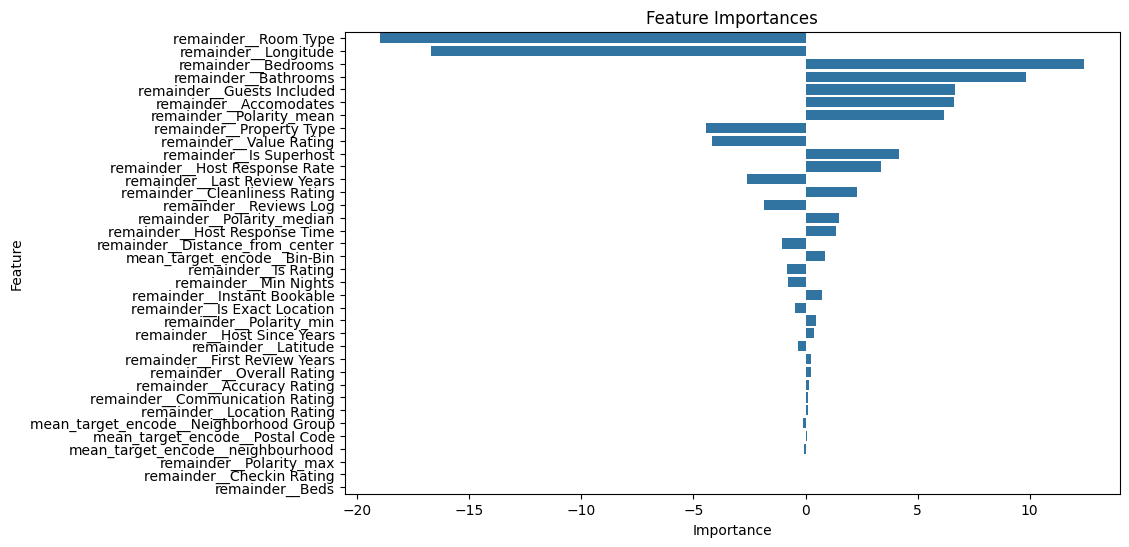

In [55]:
# prompt: важность признаков для Lasso и график

# Get feature importances
importances = pipeline.named_steps['model'].coef_

# Get feature names from preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', key = abs,  ascending=False)

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


# CatBoost feature importance

for CatBost no nessery to make encoding and Nan

In [ ]:
# X[['Overall Rating', 'Accuracy Rating',  'Cleanliness Rating', 'Checkin Rating',
#    'Communication Rating',  'Location Rating', 'Value Rating', 'Polarity_min',
#    'Polarity_max', 'Polarity_median', 'Polarity_mean']] = \
# X[['Overall Rating', 'Accuracy Rating',  'Cleanliness Rating', 'Checkin Rating',
#    'Communication Rating',  'Location Rating', 'Value Rating', 'Polarity_min',
#    'Polarity_max', 'Polarity_median', 'Polarity_mean']].fillna(-2)


In [27]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# !pip install catboost -q
# from catboost import CatBoostRegressor, Pool  # Now CatBoost is available

X = apartments.drop(['Listing ID', 'Price'], axis=1)
y = apartments['Price']

num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(exclude='number').columns

for col in cat_features:
    if X[col].dtype != 'str':
        X[col] = X[col].astype(str)

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Convert cat_features to a list
cat_features = cat_features.tolist()  # This is the key change

# Создаем модели для обучающей и тестовой выборок с указанием категориальных признаков
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Инициализируем и обучаем модель
model = CatBoostRegressor(iterations=2000, learning_rate=0.02, depth=6, verbose=100)
model.fit(train_pool)

# Предсказания на обучающей и тестовой выборках
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики для обучающей выборки
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Вычисляем метрики для тестовой выборки
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Выводим метрики на обучающей выборке
print("Metrics on Training Set:")
print(f"Mean Squared Error: {train_mse}")
print(f"Mean Absolute Error: {train_mae}")
print(f"R^2 Score: {train_r2}")

# Выводим метрики на тестовой выборке
print("\nMetrics on Test Set:")
print(f"Mean Squared Error: {test_mse}")
print(f"Mean Absolute Error: {test_mae}")
print(f"R^2 Score: {test_r2}")


# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature_name, importance in feature_importance_tuples:
    print(f'Feature: {feature_name}, Importance: {importance}')


0:	learn: 38.3285616	total: 61.6ms	remaining: 2m 3s
100:	learn: 26.3245614	total: 5.14s	remaining: 1m 36s
200:	learn: 24.9866660	total: 10.9s	remaining: 1m 37s
300:	learn: 24.4170057	total: 15.6s	remaining: 1m 28s
400:	learn: 24.0701614	total: 22.1s	remaining: 1m 28s
500:	learn: 23.7542521	total: 24.2s	remaining: 1m 12s
600:	learn: 23.4303182	total: 26.2s	remaining: 1m 1s
700:	learn: 23.1346202	total: 28.2s	remaining: 52.3s
800:	learn: 22.8841189	total: 30.2s	remaining: 45.2s
900:	learn: 22.6550670	total: 34.7s	remaining: 42.4s
1000:	learn: 22.4415219	total: 37.3s	remaining: 37.2s
1100:	learn: 22.2522112	total: 39.3s	remaining: 32.1s
1200:	learn: 22.0771438	total: 41.2s	remaining: 27.4s
1300:	learn: 21.9053787	total: 43.2s	remaining: 23.2s
1400:	learn: 21.7422985	total: 45.5s	remaining: 19.5s
1500:	learn: 21.5769751	total: 49s	remaining: 16.3s
1600:	learn: 21.4337472	total: 50.9s	remaining: 12.7s
1700:	learn: 21.2911574	total: 52.9s	remaining: 9.29s
1800:	learn: 21.1505865	total: 54.8s

                 Feature  Importance
0               Bedrooms   18.387098
1                   Beds   13.515727
2             Min Nights    9.081170
3        Accuracy Rating    5.776791
4        Guests Included    5.655156
5      Is Exact Location    4.219516
6            Postal Code    4.181802
7               Latitude    4.045204
8     Host Response Rate    3.887599
9            Reviews Log    3.000494
10             Room Type    2.694265
11  Distance_from_center    2.645261
12         Property Type    2.470135
13             Is Rating    2.446479
14             Longitude    1.820334
15    First Review Years    1.714377
16    Cleanliness Rating    1.563382
17    Neighborhood Group    1.474691
18          Polarity_max    1.368473
19     Last Review Years    1.262287
20        Checkin Rating    1.226006
21         neighbourhood    1.224529
22       Location Rating    1.210462
23        Overall Rating    1.063352
24      Host Since Years    1.001078
25    Host Response Time    0.562296
2

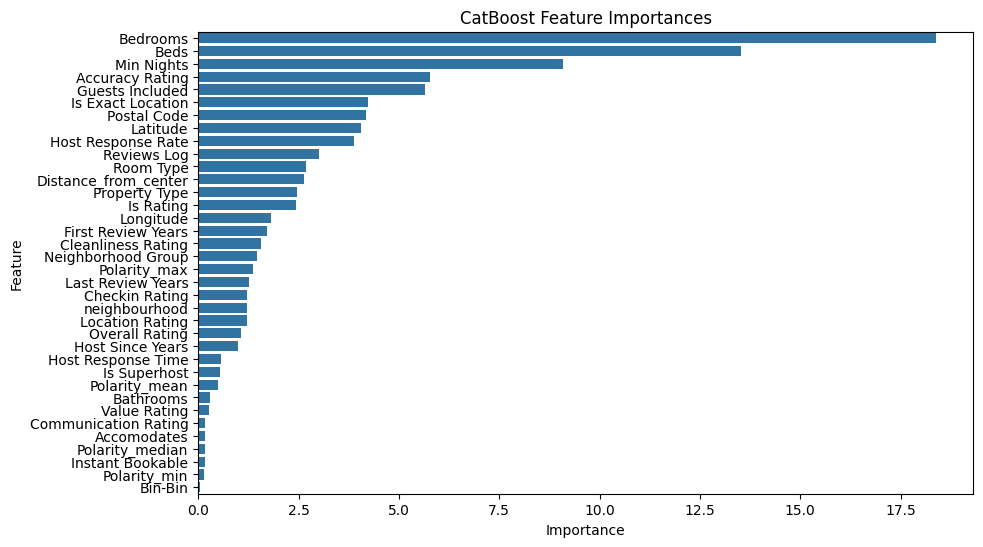

In [15]:
# prompt: важность признаков для CatBoostRegressor и добавь график вроде # Print or plot the feature importances

# Выводим важность признаков
feature_importances = model.get_feature_importance(train_pool)
# Create a list of tuples (feature_name, importance)
feature_importance_tuples = []
for feature_index in range(len(feature_importances)):
    if feature_index < len(num_features):
        feature_name = num_features[feature_index]
    else:
        feature_name = cat_features[feature_index - len(num_features)]
    importance = feature_importances[feature_index]
    feature_importance_tuples.append((feature_name, importance))

# Sort the list of tuples by importance in descending order
feature_importance_tuples.sort(key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame(feature_importance_tuples, columns=['Feature', 'Importance'])

# Print or plot the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('CatBoost Feature Importances')
plt.show()


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = apartments.drop(['Listing ID'], axis=1)

# Выделяем категориальные признаки
categorical_features = df.select_dtypes(exclude='number').columns


# Закодируем категориальные переменные
le = LabelEncoder()
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# Разделим признаки и целевую переменную
X = df.drop('Price', axis=1)
y = df['Price']

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=179)

# Создадим объект модели
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.02, max_depth=5, verbosity=1)


# Определим eval_set для контроля обучения
eval_set = [(X_train, y_train), (X_test, y_test)]

# Обучим модель с выводом RMSE на каждой итерации, убираем evals_result
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# # Обучим модель
# model.fit(X_train, y_train)

# Предсказания на тренировочной и тестовой выборках
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Вывод метрик
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

print("Training R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")


[0]	validation_0-rmse:38.27791	validation_1-rmse:38.16144
[1]	validation_0-rmse:37.88840	validation_1-rmse:37.81280
[2]	validation_0-rmse:37.51118	validation_1-rmse:37.47464
[3]	validation_0-rmse:37.14292	validation_1-rmse:37.14652
[4]	validation_0-rmse:36.78604	validation_1-rmse:36.82574
[5]	validation_0-rmse:36.43823	validation_1-rmse:36.51635
[6]	validation_0-rmse:36.10121	validation_1-rmse:36.21606
[7]	validation_0-rmse:35.77020	validation_1-rmse:35.92458
[8]	validation_0-rmse:35.45212	validation_1-rmse:35.64407
[9]	validation_0-rmse:35.14096	validation_1-rmse:35.37467
[10]	validation_0-rmse:34.84072	validation_1-rmse:35.10998
[11]	validation_0-rmse:34.54566	validation_1-rmse:34.85490
[12]	validation_0-rmse:34.26222	validation_1-rmse:34.60727
[13]	validation_0-rmse:33.98534	validation_1-rmse:34.36556
[14]	validation_0-rmse:33.71511	validation_1-rmse:34.13894
[15]	validation_0-rmse:33.45422	validation_1-rmse:33.90744
[16]	validation_0-rmse:33.19970	validation_1-rmse:33.69434
[17]	va


Feature importance in descending order:
Host Since Years: 1852.0
Postal Code: 1755.0
Accomodates: 1562.0
Longitude: 1529.0
First Review Years: 1529.0
Last Review Years: 1497.0
Distance_from_center: 1455.0
Latitude: 1105.0
Bin-Bin: 1060.0
Host Response Rate: 1044.0
Polarity_mean: 899.0
Polarity_median: 800.0
Bedrooms: 785.0
Guests Included: 764.0
neighbourhood: 747.0
Polarity_max: 735.0
Reviews Log: 709.0
Overall Rating: 696.0
Min Nights: 653.0
Polarity_min: 558.0
Room Type: 556.0
Beds: 546.0
Value Rating: 433.0
Neighborhood Group: 428.0
Host Response Time: 387.0
Cleanliness Rating: 367.0
Bathrooms: 288.0
Checkin Rating: 259.0
Is Superhost: 180.0
Communication Rating: 156.0
Instant Bookable: 151.0
Is Exact Location: 132.0
Property Type: 123.0
Location Rating: 119.0
Accuracy Rating: 84.0


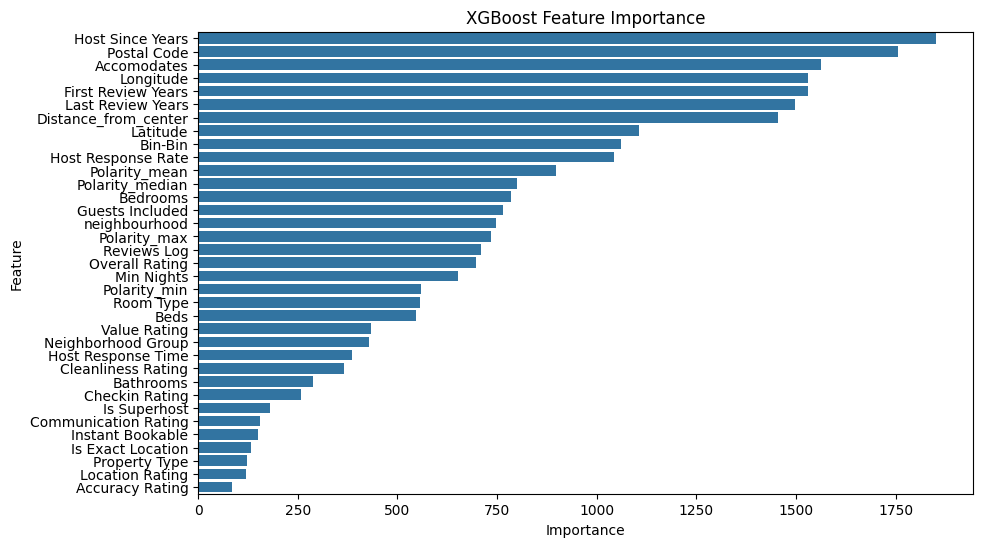

In [51]:
# prompt: важность признаков для XGBoostRegressor и добавь график

# Важность признаков
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Вывод важности признаков в порядке убывания
print("\nFeature importance in descending order:")
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

# Создание DataFrame для визуализации
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance')
plt.show()


# Encoding

Converting categorical data to numerical

In [ ]:
categorical_cols = apartments.select_dtypes(exclude='number').columns
for col in categorical_cols:
  print(f"Value counts for column '{col}' :")
  print(apartments[col].value_counts())
  print(f"NaN values: {apartments[col].isnull().sum()} ")
  print()
  print()

In [ ]:
# Perform one-hot encoding and drop the first column
neighborhood_dummies = pd.get_dummies(apartments['Neighborhood Group'], prefix='Neighborhood', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
apartments = pd.concat([apartments, neighborhood_dummies], axis=1)

In [ ]:
numeric_columns = apartments.select_dtypes(include=['number']).columns

print(numeric_columns)

Index(['Host Response Time', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Is Exact Location', 'Property Type', 'Room Type',
       'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating',
       'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating',
       'Communication Rating', 'Location Rating', 'Value Rating',
       'Instant Bookable', 'Polarity_min', 'Polarity_max', 'Polarity_median',
       'Polarity_mean', 'Host Since Years', 'Last Review Years',
       'First Review Years', 'Latitude_Bin', 'Longitude_Bin', 'Price Log',
       'Reviews Log', 'Distance_from_center'],
      dtype='object')


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

numeric_columns = numeric_columns.drop(['Price Log'])

df = apartments[numeric_columns].copy()

# Предположим, что df - ваш датафрейм
X = df.drop('Price', axis=1)
y = df['Price']

# Создаем модель Лассо
model = Lasso(alpha=0.1)  # Параметр alpha регулирует степень регуляризации
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

print(f"\n Lasso")
print(f"R^2: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


# Важность признаков
feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print("Feature importance using Lasso:")
print(feature_importance)

ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#apartments.to_excel('apartments_6.xlsx', index=False)

# import pickle
with open('apartments6.pkl', 'wb') as f:
    pickle.dump(apartments, f)


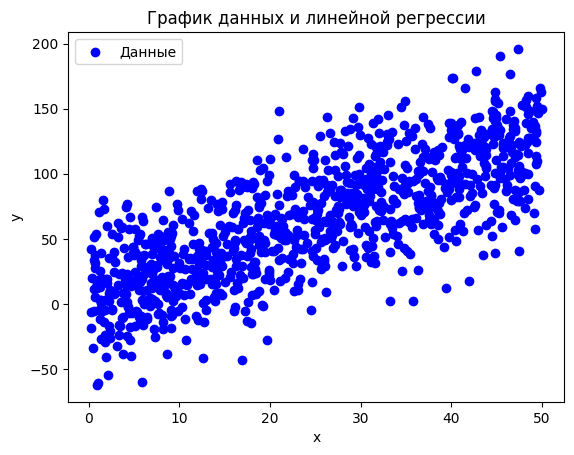

0.5846297813720505

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Случайные данные с известным R^2
np.random.seed(42)
x = np.random.rand(1000, 1) * 50  # переменная x в диапазоне от 0 до 10
y = 2.5 * x + np.random.normal(0, 30, size=(1000, 1))  # линейная зависимость с добавлением шума

# Модель линейной регрессии
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Подсчет R^2
r2 = r2_score(y, y_pred)


# Построение графика
plt.scatter(x, y, color='blue', label='Данные')
##plt.plot(x, y_pred, color='red', label=f'Линейная регрессия\n$R^2$ = {r2:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('График данных и линейной регрессии')
plt.legend()
plt.show()

r2